In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
import re
from deep_translator import GoogleTranslator

from tqdm import tqdm

plt.style.use('ggplot')

import nltk
from nltk.tokenize import word_tokenize
from LeIA import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from spellchecker import SpellChecker

from sklearn.model_selection import train_test_split
from datasets import load_dataset, DatasetDict, Dataset

from google_play_scraper import Sort, reviews, app

In [2]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/raycalm/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
apps_ids = ['br.com.brainweb.ifood', 'com.cerveceriamodelo.modelonow',

'com.mcdo.mcdonalds', 'habibs.alphacode.com.br',

'com.ubercab.eats', 'com.grability.rappi',

'burgerking.com.br.appandroid', 

'com.vanuatu.aiqfome',

'br.com.sbf.centauro',

'br.com.riachuelo.app',

'com.mercadolibre',

'com.cerveceriamodelo.modelonow',

'com.amazon.mShop.android.shopping',

'br.gov.meugovbr',

'com.b2w.americanas',

'br.com.lojasrenner',

'br.com.marisa.android',

'com.zzkko',

'com.luizalabs.mlapp']

In [4]:
apps_reviews = []

for ap in tqdm(apps_ids):
    for score in list(range(1, 6)):
        for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]:
            rvs, _ = reviews(
                ap,
                lang='pt',
                country='br',
                sort=sort_order,
                count= 200 if score == 3 else 100,
                filter_score_with=score
            )
            for r in rvs:
                r['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
                r['appId'] = ap
            apps_reviews.extend(rvs)

100%|██████████| 19/19 [01:01<00:00,  3.25s/it]


In [5]:
df = pd.DataFrame(apps_reviews)

In [6]:
df = df.drop(['reviewId'], axis=1)
df['id'] = range(1, len(df) + 1)

In [7]:
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sortOrder,appId,id
0,RYBADI GAMER,https://play-lh.googleusercontent.com/a-/ALV-U...,As últimas atualizações deixaram o aplicativo ...,1,32,10.24.0,2024-07-15 20:18:23,None,NaT,10.24.0,most_relevant,br.com.brainweb.ifood,1
1,Guilherme Gomes,https://play-lh.googleusercontent.com/a/ACg8oc...,Um lixo de aplicativo. Cada vez mais a experiê...,1,60,10.24.0,2024-07-08 17:11:27,None,NaT,10.24.0,most_relevant,br.com.brainweb.ifood,2
2,Guidi Yu,https://play-lh.googleusercontent.com/a-/ALV-U...,O atendimento pelo chat no geral era bom. Hoje...,1,69,10.24.0,2024-07-05 21:21:42,None,NaT,10.24.0,most_relevant,br.com.brainweb.ifood,3
3,Luis Martins,https://play-lh.googleusercontent.com/a/ACg8oc...,Estou bem decepcionado com o app. É cada vez m...,1,13,10.24.0,2024-07-13 17:02:54,None,NaT,10.24.0,most_relevant,br.com.brainweb.ifood,4
4,Igor Fernandez,https://play-lh.googleusercontent.com/a/ACg8oc...,"Com certeza um dos piores apps que tenho, volu...",1,72,10.24.0,2024-07-04 19:58:07,None,NaT,10.24.0,most_relevant,br.com.brainweb.ifood,5


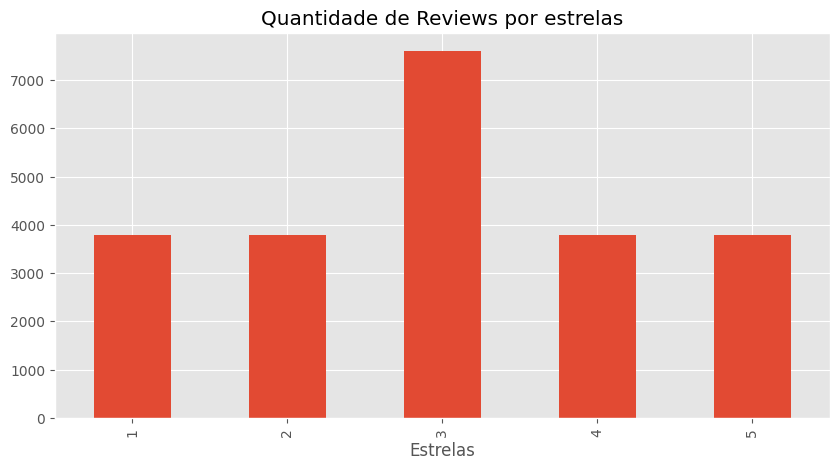

In [8]:
ax = df['score'].value_counts().sort_index().plot(kind='bar', title='Quantidade de Reviews por estrelas', figsize=(10, 5))
ax.set_xlabel('Estrelas')
plt.show()

### NLTK Básico

In [9]:
WORD_MIN_LENGTH = 2
STOP_WORDS_PT = [stop_word.lower() for stop_word in nltk.corpus.stopwords.words('portuguese')]
spell = SpellChecker(language='pt')

def strip_accents(text):
    nfkd = unicodedata.normalize('NFKD', text)
    stripped_text = u"".join([c for c in nfkd if not unicodedata.combining(c)])
    return re.sub('[^a-zA-Z]', ' ', stripped_text)

def tokenize(text):
    text = strip_accents(text)
    text = re.sub(re.compile('\n'),' ',text)
    words = word_tokenize(text)
    words = [word.lower() for word in words]
    words = [word for word in words if word not in STOP_WORDS_PT and len(word) >= WORD_MIN_LENGTH]
    return words

def lemmatize(text):
    lemmatized_text = []
    for (word) in text:
        lemmatizing = str(WordNetLemmatizer().lemmatize(word))
        lemmatized_text.append(lemmatizing)
    return lemmatized_text

def preprocess_stl(array):
    preprocessed = []

    stripped_rvs = [strip_accents(rvs) for rvs in array]
    tokenized_rvs = [tokenize(rvs) for rvs in stripped_rvs]
    lemmatized_rvs = [lemmatize(rvs) for rvs in tokenized_rvs]

    preprocessed = lemmatized_rvs

    return preprocessed



## Utilizando VADER
Abordagem BoW - removeremos stop words e cada palavra remeterá a uma pontuação e essas pontuações serão combinadas para obter uma pontuação final

In [10]:
sia = SentimentIntensityAnalyzer()
# translator = GoogleTranslator(source='pt', target='en')

In [11]:
# def translate_and_analyze(text, myid):
#     try:
#         translated_text = translator.translate(text)
#         if translated_text is None:
#             raise ValueError("Translation returned None")
#         sentiment = sia.polarity_scores(translated_text)
#         return myid, sentiment
#     except Exception as e:
#         return myid, {"error": str(e)}

In [12]:
# df_sample = df.sample(n=500, random_state=42)

res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['content']
    myid = row['id']
    res[myid] = sia.polarity_scores(text)

100%|██████████| 22800/22800 [00:15<00:00, 1508.68it/s]


In [13]:
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sortOrder,appId,id
0,RYBADI GAMER,https://play-lh.googleusercontent.com/a-/ALV-U...,As últimas atualizações deixaram o aplicativo ...,1,32,10.24.0,2024-07-15 20:18:23,None,NaT,10.24.0,most_relevant,br.com.brainweb.ifood,1
1,Guilherme Gomes,https://play-lh.googleusercontent.com/a/ACg8oc...,Um lixo de aplicativo. Cada vez mais a experiê...,1,60,10.24.0,2024-07-08 17:11:27,None,NaT,10.24.0,most_relevant,br.com.brainweb.ifood,2
2,Guidi Yu,https://play-lh.googleusercontent.com/a-/ALV-U...,O atendimento pelo chat no geral era bom. Hoje...,1,69,10.24.0,2024-07-05 21:21:42,None,NaT,10.24.0,most_relevant,br.com.brainweb.ifood,3
3,Luis Martins,https://play-lh.googleusercontent.com/a/ACg8oc...,Estou bem decepcionado com o app. É cada vez m...,1,13,10.24.0,2024-07-13 17:02:54,None,NaT,10.24.0,most_relevant,br.com.brainweb.ifood,4
4,Igor Fernandez,https://play-lh.googleusercontent.com/a/ACg8oc...,"Com certeza um dos piores apps que tenho, volu...",1,72,10.24.0,2024-07-04 19:58:07,None,NaT,10.24.0,most_relevant,br.com.brainweb.ifood,5


In [14]:
vaders = pd.DataFrame(res).T
vaders.reset_index(inplace=True)
vaders = vaders.rename(columns={'index': 'id'})
vaders = vaders.merge(df, how='left', on='id')

In [15]:
vaders = vaders.drop(['userImage', 'reviewCreatedVersion', 'replyContent', 'sortOrder', 'thumbsUpCount', 'at', 'repliedAt', 'appVersion', 'userName'], axis=1)

In [16]:
vaders.head()

,id,neg,neu,pos,compound,content,score,appId
0,1,0.222,0.671,0.107,-0.8225,As últimas atualizações deixaram o aplicativo ...,1,br.com.brainweb.ifood
1,2,0.121,0.783,0.096,-0.2023,Um lixo de aplicativo. Cada vez mais a experiê...,1,br.com.brainweb.ifood
2,3,0.109,0.774,0.117,0.1280,O atendimento pelo chat no geral era bom. Hoje...,1,br.com.brainweb.ifood
3,4,0.193,0.783,0.024,-0.8765,Estou bem decepcionado com o app. É cada vez m...,1,br.com.brainweb.ifood
4,5,0.078,0.864,0.058,-0.2732,"Com certeza um dos piores apps que tenho, volu...",1,br.com.brainweb.ifood


In [17]:
vaders = vaders.dropna(subset=['pos', 'neg', 'neu'])

In [18]:
vaders.to_csv('./vaders.csv')

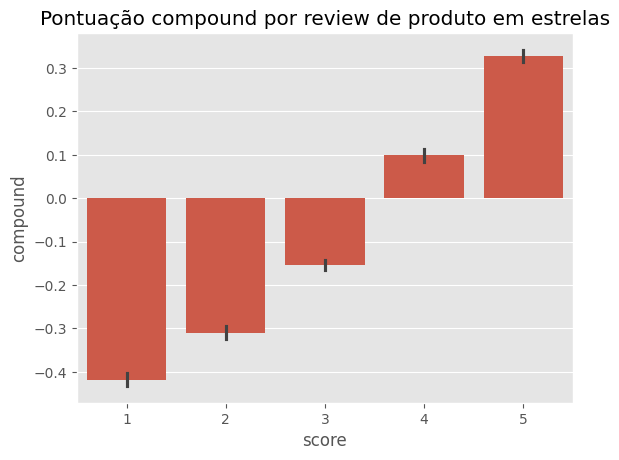

In [19]:
ax = sns.barplot(data=vaders, x='score', y='compound')
ax.set_title('Pontuação compound por review de produto em estrelas')
plt.show()

Quando menor a pontuação compound, menor a quantidade de estrelas dada pelo consumidor.

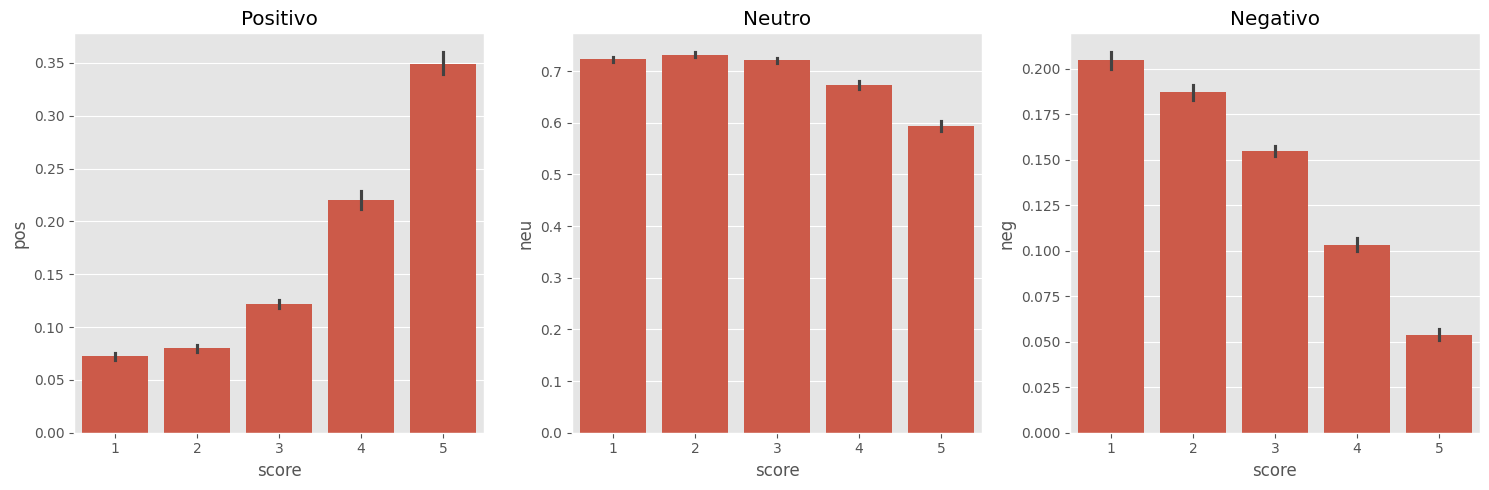

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(data=vaders, x='score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='score', y='neg', ax=axs[2])

axs[0].set_title('Positivo')
axs[1].set_title('Neutro')
axs[2].set_title('Negativo')

plt.tight_layout()
plt.show()

## Utilizando BERT

In [21]:
from transformers import pipeline
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from scipy.special import softmax

In [22]:
# MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = BertTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = BertForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [23]:
# Exemplo executado para VADER

example = df['content'][0]
vader_result = sia.polarity_scores(example)

print(example)
print(vader_result)

As últimas atualizações deixaram o aplicativo horrível, principalmente para resolver possíveis buchas, o app agora não tem opção de cancelamento, o sistema automatizado nem sempre funciona, as vezes, tem aguardar dias para solucionar, o chat fica em aberto e nada. De antemão comprar no iFood está inseguro, já que o estabelecimento ou entregador que fica em responsável de deferir possível cancelamento, por item atrasado, ou pedido entregue errado ou divergente do contratado. Não recomendo.
{'neg': 0.222, 'neu': 0.671, 'pos': 0.107, 'compound': -0.8225}


#### Exemplo de classificação com BERT

In [24]:
classifier = pipeline('sentiment-analysis', model='nlptown/bert-base-multilingual-uncased-sentiment')

result = classifier(example)

print(result)


[{'label': '1 star', 'score': 0.8262738585472107}]


### Agora realizamos o fine-tuning do BERT para os interesses de classificar as emoções em 'alegria', 'satisfação', 'neutro', 'decepção' e 'raiva'

Vamos rotular as linhas do dataframe para utilizar este para treinar o modelo, fazendo o fine-tuning deste

In [25]:
df_labeled = df.drop(['userImage', 'reviewCreatedVersion', 'replyContent', 'sortOrder', 'thumbsUpCount', 'at', 'repliedAt', 'appVersion', 'userName'], axis=1)
df_labeled

,content,score,appId,id
0,As últimas atualizações deixaram o aplicativo ...,1,br.com.brainweb.ifood,1
1,Um lixo de aplicativo. Cada vez mais a experiê...,1,br.com.brainweb.ifood,2
2,O atendimento pelo chat no geral era bom. Hoje...,1,br.com.brainweb.ifood,3
3,Estou bem decepcionado com o app. É cada vez m...,1,br.com.brainweb.ifood,4
4,"Com certeza um dos piores apps que tenho, volu...",1,br.com.brainweb.ifood,5
...,...,...,...,...
22795,Fantástica!,5,com.luizalabs.mlapp,22796
22796,Excelência e respeito com o consumidor é na ma...,5,com.luizalabs.mlapp,22797
22797,Excelente compra no app,5,com.luizalabs.mlapp,22798
22798,Atendimento rápido,5,com.luizalabs.mlapp,22799


In [26]:
df_labeled.to_csv('./df_labeled.csv')

In [27]:
# Essas são as emoções que queremos classificar - ou ausência de emoção, no caso de ser um comentário neutro
labels = ["raiva", "decepção", "neutro", "satisfação", "alegria"]

In [28]:
df_semilabeled = pd.read_csv('./df_semilabeled.csv')
df_semilabeled = df_semilabeled.dropna(subset=['emotion'])
df_train = df_semilabeled[df_semilabeled['emotion'] != 'deletar']

In [29]:
df_train.shape

(1012, 6)

In [30]:
df_train = df_train.drop(['Unnamed: 0', 'appId', 'id', 'score'], axis=1)

In [31]:
df_extra_rvs = pd.read_csv('./more_reviews.csv')
df_extra_rvs.shape

(600, 2)

In [32]:
df_train = pd.concat([df_train, df_extra_rvs], ignore_index=True)

In [33]:
df_train.shape

(1612, 2)

In [34]:
print(f"Quantidade de avaliações com teor sentimental 'satisfação': {len(df_train[df_train['emotion'] == 'satisfação'])}")
print(f"Quantidade de avaliações com teor sentimental 'alegria': {len(df_train[df_train['emotion'] == 'alegria'])}")
print(f"Quantidade de avaliações com teor sentimental 'neutro': {len(df_train[df_train['emotion'] == 'neutro'])}")
print(f"Quantidade de avaliações com teor sentimental 'decepção': {len(df_train[df_train['emotion'] == 'decepção'])}")
print(f"Quantidade de avaliações com teor sentimental 'raiva': {len(df_train[df_train['emotion'] == 'raiva'])}")

Quantidade de avaliações com teor sentimental 'satisfação': 350
Quantidade de avaliações com teor sentimental 'alegria': 409
Quantidade de avaliações com teor sentimental 'neutro': 37
Quantidade de avaliações com teor sentimental 'decepção': 426
Quantidade de avaliações com teor sentimental 'raiva': 384


In [35]:
df_test = df_labeled[~df_labeled['content'].isin(df_train['content'])]
df_test = df_test.drop(['appId', 'id', 'score'], axis=1)

In [36]:
# Criando um mapa para as emoções de interesse da análise

emotion_dict = {
    'raiva': 1,
    'decepção': 2,
    'neutro': 3,
    'satisfação': 4,
    'alegria': 5
}



In [37]:
df_train['emotion'] = df_train['emotion'].map(emotion_dict)

# Agora temos números inteiros as emoções

In [38]:
# Transformando os DataFrames em datasets Hugging Face

train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)

In [39]:
# Função para tokenizar as avaliações

def tokenize_function(df):
    return tokenizer(df['content'], padding='max_length', truncation=True)


In [40]:
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1612 [00:00<?, ? examples/s]

Map:   0%|          | 0/21088 [00:00<?, ? examples/s]

In [41]:
# Configurando argumentos de treinamento
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='epoch'
)

# Inicializando Hugging Face Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

/home/raycalm/.local/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


: 

In [42]:
trainer.train()

  0%|          | 0/606 [00:00<?, ?it/s]

In [ ]:
# inputs = tokenizer(example, return_tensors='pt', padding=True, truncation=True)
# outputs = model(**inputs)
# scores = outputs.logits[0].detach().numpy()
# scores = softmax(scores)
# predicted_label = labels[scores.argmax()]
# print(scores)
# print(scores.argmax())
# print(predicted_label)

In [ ]:
# def predict_emotion(text):
#     inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
#     outputs = model(**inputs)
#     scores = outputs.logits[0].detach().numpy()
#     scores = softmax(scores)
#     predicted_label = labels[scores.argmax()]
#     return predicted_label


# df_labeled['predicted_emotion'] = df_labeled['content'].apply(predict_emotion)